# Title

#### Predictive Modelling of Subscribers in Plaicraft

# Introduction
A research group is collecting data about how people play video games. They have set up a MineCraft server, and players’ actions are recorded as they navigate through the world. For running this project, they need to target their recruitment efforts, and make sure they have enough resources to handle the number of players they attract. The purpose of our project is to provide an idea for this and use data analysis to prove whether this idea can effectively assist their recruitment.

Understanding how players interact with a game environment is essential for improving recruitment strategies, managing server resources, and designing engaging gameplay experiences. For example, newsletter subscription can serve as a meaningful indicator of player engagement and long-term interest. Players who subscribe may be more invested in game updates, community events, or new content, and identifying the characteristics of these players can support more effective recruitment and communication strategies.

In this project, we focus on two predictors available in the player dataset—**age and total play time**—and examine whether these variables can be used to predict newsletter subscription status. Our research question is therefore:

**Can a player's age and play time be used to predict whether or not they are subscribed to a game-related newsletter.**

To investigate this, we clean and summarize the `players.csv` dataset, explore the relationships between age, play time, and subscription, and build a predictive classification model using K-Nearest Neighbours (KNN). The results allow us to evaluate how well these behavioural and demographic attributes distinguish between subscribed and non-subscribed players, and to assess their usefulness for informing future recruitment strategies.

In [5]:
# Load the required libraries
library(tidyverse)
library(tidymodels)

# Read the Data
players <- read_csv("https://raw.githubusercontent.com/achan919/dsci-final-project/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


# Data Description
The file `players.csv` was collected by a research group in Computer Science at UBC to help us complete our project. It contains 196 players’ information and 7 variables columns:

| Variable     |Data Type | Description |
|--------------|----------|-------------|
| experience   | chr |Level of experience (Pro, Veteran, Amateur, Regular, Beginner) |
| subscribe    | lgl |Whether the player subscribed to the newsletter |
| hashedEmail  | chr | Hashed/hidden email of the player |
| played_hours | dbl |Total hours played (mean = 5.846) |
| name         | chr |Player's first name |
| gender       | chr |Gender (Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other) |
| Age          | dbl |Player age in years (mean = 21.14) |

# Methods & Results

### **1. Wrangling + Cleaning**

For our predictive analysis, we focus on three key variables relevant to our research question: **Age, played_hours, and subscribe**. Since the `subscribe` variable was originally stored as a logical type (TRUE/FALSE), we converted it into a categorical factor with descriptive labels (“Subscribed” and “Not Subscribed”). This improves interpretability and ensures proper handling during visualization and modeling.

The dataset contained two missing values in the `Age` variable. Because KNN cannot operate on missing predictor values, we removed these rows to maintain a clean and fully usable dataset.

In [6]:
# Tidy the players data set: give more descriptive labels and discard two rows which lack of 
players_tidy <- players |>
select(Age, played_hours, subscribe) |>
  mutate(subscribe = factor(subscribe,  
                            levels = c(FALSE, TRUE), 
                            labels = c("Not Subscribed", "Subscribed"))) |>
 filter(!is.na(Age))
head(players_tidy)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,Subscribed
17,3.8,Subscribed
17,0.0,Not Subscribed
21,0.7,Subscribed
21,0.1,Subscribed
17,0.0,Subscribed


### **2. Exploratory Data Analysis**

Before conducting predictive modeling, we performed exploratory data analysis (EDA) to better understand the distribution of the key variables. To identify the most common age groups among players, we aggregated the data by age and extracted the ten most frequent age values. Then we filtered the player dataset to keep only observations belonging to these top age groups, which allowed us to visualize the age distribution more clearly.

In [7]:
# Summary of player dataset
players_summary <- summary(players_tidy)
players_summary

# Summarize player counts by age and extract the top 10 most frequent ages
top10_age_distribution <- players_tidy |>
  group_by(Age) |>
    summarize(
        count = n()) |>
  slice_max(count , n = 10)
top10_age_distribution

players_top10 <- players_tidy |>
  semi_join(top10_age_distribution, by = "Age")

      Age         played_hours              subscribe  
 Min.   : 9.00   Min.   :  0.000   Not Subscribed: 52  
 1st Qu.:17.00   1st Qu.:  0.000   Subscribed    :142  
 Median :19.00   Median :  0.100                       
 Mean   :21.14   Mean   :  5.905                       
 3rd Qu.:22.75   3rd Qu.:  0.600                       
 Max.   :58.00   Max.   :223.100                       

Age,count
<dbl>,<int>
17,73
21,18
22,15
20,14
23,13
24,10
18,7
19,7
26,4


### **3. Visualizations**

#### Visualization 1: Age Distribution

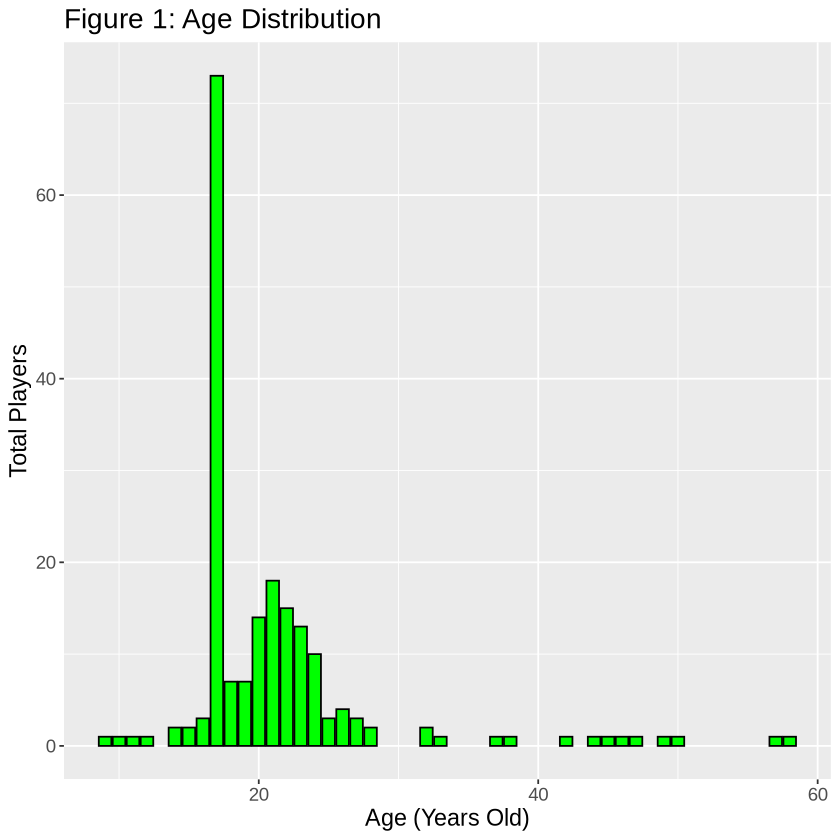

In [8]:
# visualization of age distribution
age_distribution_plot <- players_tidy |>
  ggplot(aes(x = Age)) +
  geom_bar(fill = "green", color = "black") +
  labs(title = "Figure 1: Age Distribution",
       x = "Age (Years Old)",
       y = "Total Players") +
  theme(text = element_text(size = 14))
age_distribution_plot

The age distribution is strongly concentrated among younger players, with most users clustered between the late teens and mid-twenties(15-25). The dataset therefore represents a predominantly young gaming population. This uneven age distribution is important to note because it affects how age contributes to predicting subscription status.

 #### Visualization 2: Played Hours Distribution

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


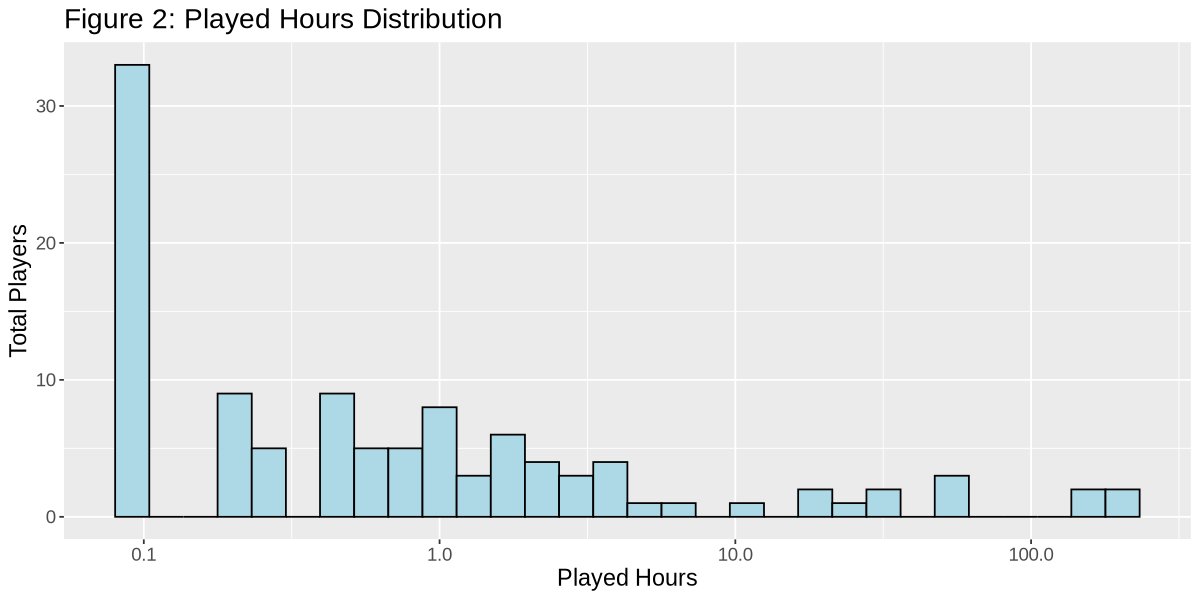

In [9]:
# visualization of played hours distribution
options(repr.plot.width = 10, repr.plot.height = 5) 

played_hours_distribution_plot <- ggplot(players_tidy, aes(x = played_hours)) +
    geom_histogram(fill = "lightblue", color = "black") +
    labs(title = "Figure 2: Played Hours Distribution",
         x = "Played Hours",
         y = "Total Players") +
  scale_x_log10() +
  theme(text = element_text(size = 14))
played_hours_distribution_plot

Total play time is heavily right-skewed: most players have relatively low play hours, while a small number of players accumulate very high play times. This suggests that play time varies widely across users and may carry predictive value for subscription status, since high-engagement players could behave differently from other players.

 #### Visualization 3: Subscription Distribution

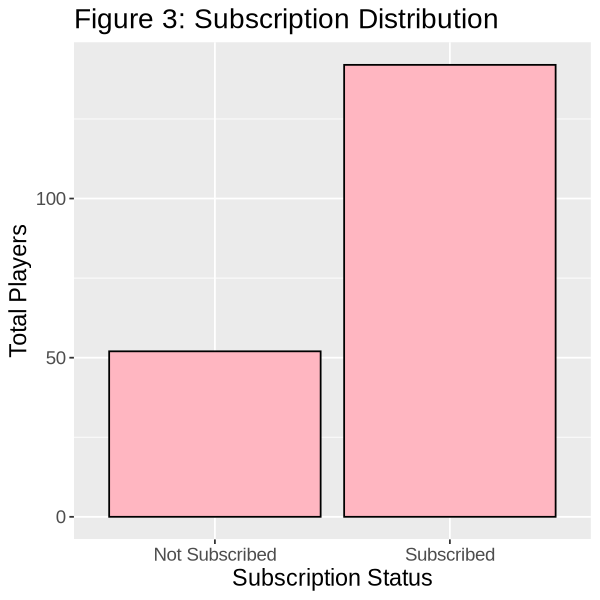

In [10]:
# visualization of subscription distribution
options(repr.plot.width = 5, repr.plot.height = 5) 

subscription_distribution_plot <- players_tidy |>
  ggplot(aes(x = subscribe)) +
  geom_bar(fill = "lightpink", color = "black") +
  labs(title = "Figure 3: Subscription Distribution",
       x = "Subscription Status",
       y = "Total Players") +
  theme(text = element_text(size = 14))
subscription_distribution_plot

The majority of players in the dataset are subscribed to the newsletter. The imbalance between subscribed and non-subscribed groups is important for modeling because predictive algorithms may need to account for class imbalance.

#### Visualization 4: A Player's Play Time By Subscription

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


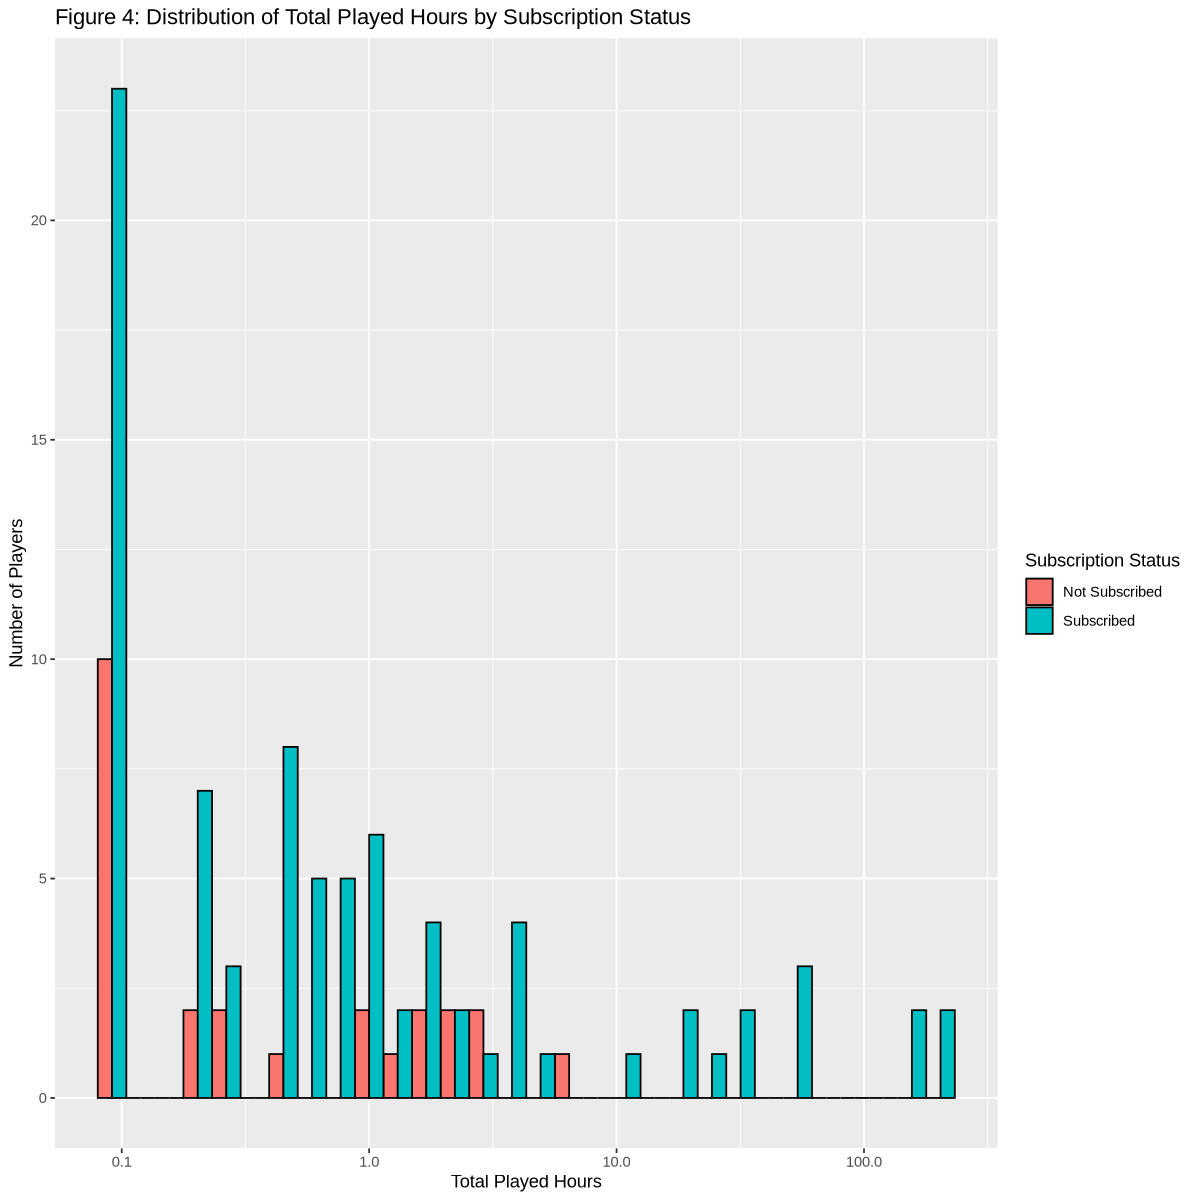

In [11]:
# visualization of player's play time distribution by subscription staus
options (repr.plot.width = 10, repr.plot.height = 10)

total_played_hours_plot <- ggplot(players_tidy, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(color = "black", position = "dodge") +
  scale_x_log10() +
  labs(
    title = "Figure 4: Distribution of Total Played Hours by Subscription Status",
    x = "Total Played Hours",
    y = "Number of Players", 
    fill = "Subscription Status"
  )
total_played_hours_plot

Players who subscribed tend to have higher played hours compared to those who did not subscribe. The subscribed group suggests a potential positive relationship between engagement (play time) and newsletter subscription. This supports using play time as a predictor in the classification model.

#### Visualization 5: A Player's Age by Subscription

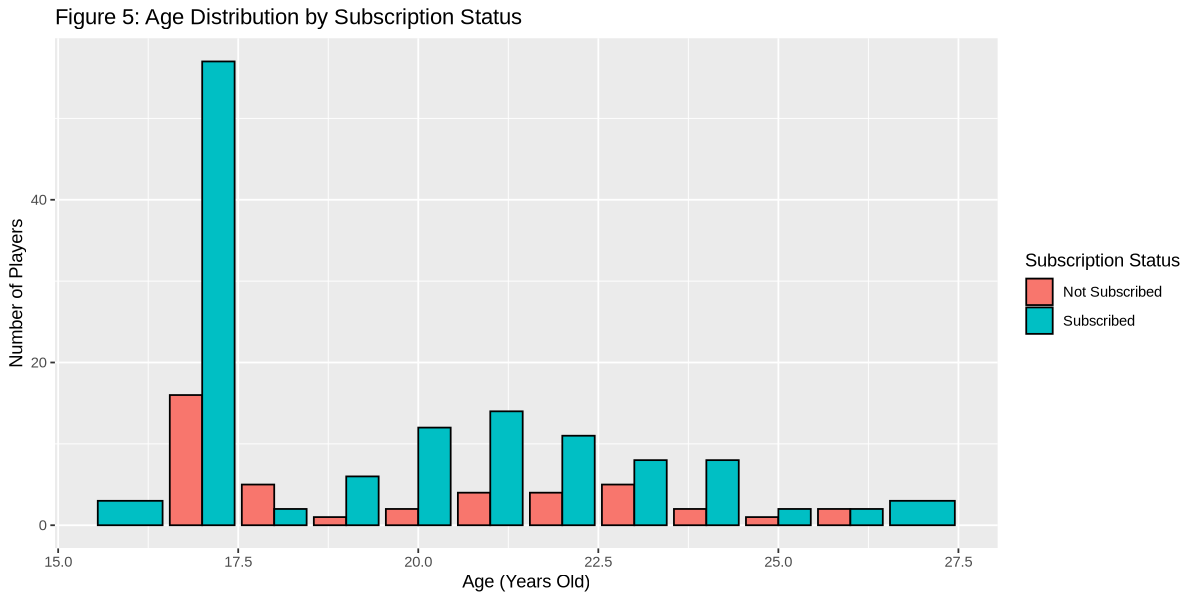

In [12]:
options (repr.plot.width = 10, repr.plot.height = 5)

# visualization of player's age distribution by subscription staus
age_plot <- ggplot(players_top10, aes(x = Age, fill = subscribe)) +
  geom_bar(color = "black", position = "dodge") +
  labs(
    title = "Figure 5: Age Distribution by Subscription Status",
    x = "Age (Years Old)",
    y = "Number of Players",
    fill = "Subscription Status"
  )
age_plot

When focusing on the most common age groups, subscribed players appear more concentrated in certain age ranges, particularly among players in their early 20s. This pattern indicates that age may still contribute moderately to subscription prediction—especially within the most represented age groups. Both visualization 4 and 5 shows us the strong correlation needed for our planned analysis.

# Discussion

needs to be worked on

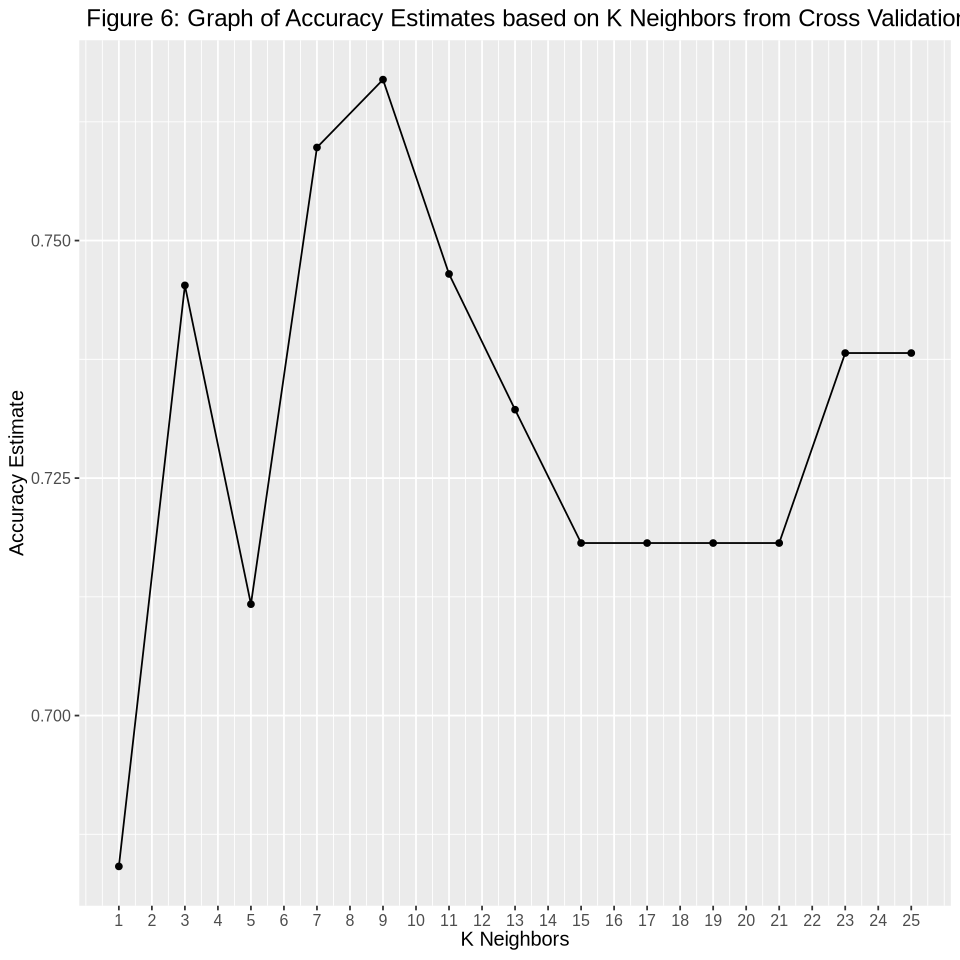

In [13]:
# Make sure the results are reproducible
set.seed(67) 
library(tidymodels)

# Split the data into training set(75%) and testing set(25%)
initial_split <- initial_split(players_tidy, prop = 0.75)
training_data <- training(initial_split)
testing_data <- testing(initial_split)

# Define the knn model specification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a data preprocessing recipe
players_recipe <- recipe(subscribe ~ played_hours + Age, data = training_data) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

# Create 5-fold cross-validation objects, stratified by subscription status
players_vfold <- vfold_cv(training_data, v = 5, strata = subscribe)

# Create the possible K value that will be applied to the model
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 2))

# Cross-validation tuning using workflows
players_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

# Filter out the accuracy
accuracies <- players_results |>
    filter(.metric == "accuracy")

options(repr.plot.width = 8, repr.plot.height = 8)

#Visualize the cross-validation accuracy
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous (breaks = seq (1, 25, by = 1)) + 
    labs(x = "K Neighbors", y = "Accuracy Estimate") +
    ggtitle(" Figure 6: Graph of Accuracy Estimates based on K Neighbors from Cross Validation") +
    theme(text = element_text(size = 12))

cross_val_plot


In [15]:
# According to the result of the cross-validation, we choose 9 as our K value 
# since it has the highest accuracy

# Redefine the KNN model specification using the best K value 9
players_spec_neighbour <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
set_engine("kknn") |>
set_mode("classification")

# Using workflow to train the final model
players_new_result <- workflow() |>
add_model(players_spec_neighbour) |>
add_recipe(players_recipe) |>
fit(training_data)

In [16]:
# Apply the trained model on the testing set to make predictions
predictions <- predict(players_new_result, testing_data) |>
bind_cols(testing_data)

# Compute the performance metrics of the model on the test set
pred_metrics <- predictions |>
metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")

predictions
pred_metrics

.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
Subscribed,21,0.1,Subscribed
Subscribed,21,0.0,Not Subscribed
Subscribed,22,0.2,Subscribed
Not Subscribed,58,0.3,Subscribed
Subscribed,21,0.7,Subscribed
Subscribed,17,0.0,Subscribed
Subscribed,23,0.0,Not Subscribed
Not Subscribed,18,0.1,Not Subscribed
Subscribed,33,0.0,Not Subscribed


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


In [17]:
# Creating the confusion matrix
players_conf_mat <- predictions |>
conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat

                Truth
Prediction       Not Subscribed Subscribed
  Not Subscribed              3          2
  Subscribed                 11         33

In [18]:
# Calculate the precision and recall (based on the confusion matrix above)

# The formula is: Precision = True Positive / (False Positive + True Positive)
precision <- round(33 / (11 + 33), 2)
precision

# The formula is: Recall = True Positive / (False Negative + True Positive)
recall <- round(33 / (2 + 33), 2)
recall

[1] 0.75

[1] 0.94

# References